In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)

In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed 

In [2]:
from modules import Series, DataLoader, EQModel, wpl
import numpy as np
from fbprophet.plot import add_changepoints_to_plot

/Users/chrisschon/miniconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
d = DataLoader()

In [4]:
d.load_lookups()

In [5]:
sales_df = d.load_sales_df({'filters':{'item_id':2314,'store_id':1}})

In [6]:
from main import evaluate, fit

In [7]:
regparams = {'regressors': ['sell_price'], 'yearly_seasonality': True, 'weekly_seasonality':True, 'add_country_holidays': 'US'}
params = {'yearly_seasonality': True, 'weekly_seasonality':True, 'add_country_holidays': 'US'}

In [8]:
s = Series(sales_df, 'sales_count')

In [9]:
tsds = pd.Series(s.tseries.values, index = sales_df['ds'])

In [10]:
model = s.fit_Prophet(ds = 'ds', y = 'sales_count', split = True, **params)
future = model.make_future_dataframe(periods=28)
future['sell_price'] = sales_df['sell_price']
forecast = model.predict(future)
pred_samples = s.predsamples_Prophet(model, forecast)
pred_quantiles = s.predsamples_quantiles(pred_samples)
pred_quantiles = pred_quantiles.applymap(lambda x: float(0) if x < 0 else x)
pred_quantiles_ds = pred_quantiles.set_index(sales_df['ds'])
scaled_pred_quantiles = pred_quantiles.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
scales = {0.005:1.0, 0.025:1.0, 0.165: 1.0, 0.995:1.18}
for k, scalar in scales.items():
    scaled_pred_quantiles[k] = scalar*pred_quantiles[k].values

In [12]:
for quant in list(pred_quantiles.columns):
    print(f'QUANTILE:{quant}')
    start_score = wpl(s.tseries, pred_quantiles[quant], tau = quant)
    print(f'start score:{start_score.round(4)}')
    minasso = start_score
    for scales in np.arange(0.8,1.2,0.02):
        score = wpl(s.tseries, scales*pred_quantiles[quant], tau = quant)
        if score < minasso:
            minasso = score
            meh = (str(scales)[:4], minasso.round(4), abs(minasso-start_score).round(5))
    print(f'BEST SCALAR:{meh}')
        #print(f'{str(scales)[:4]}: {score}')
    

QUANTILE:0.005
start score:0.1484
BEST SCALAR:('0.8', 0.1481, 0.00032)
QUANTILE:0.025
start score:0.801
BEST SCALAR:('0.8', 0.7851, 0.0159)
QUANTILE:0.165
start score:4.2701
BEST SCALAR:('1.14', 4.2496, 0.02057)
QUANTILE:0.25
start score:5.5115
BEST SCALAR:('1.10', 5.4712, 0.04036)
QUANTILE:0.5
start score:7.1498
BEST SCALAR:('1.10', 5.4712, 0.04036)
QUANTILE:0.75
start score:6.2842
BEST SCALAR:('0.94', 6.2206, 0.06361)
QUANTILE:0.835
start score:5.242
BEST SCALAR:('0.94', 5.1848, 0.05722)
QUANTILE:0.975
start score:1.7269
BEST SCALAR:('1.12', 1.6804, 0.04646)
QUANTILE:0.995
start score:0.6861
BEST SCALAR:('1.18', 0.5496, 0.13651)


In [13]:
proph_eval = evaluate(scaled_pred_quantiles, s.tseries)
proph_eval_tr = evaluate(scaled_pred_quantiles.iloc[:-28,:], s.tstrain)
proph_eval_te = evaluate(scaled_pred_quantiles.iloc[-28:, :], s.tstest)
score = proph_eval['wpl'].mean().round(3)
score_tr = proph_eval_tr['wpl'].mean().round(3)
score_te = proph_eval_te['wpl'].mean().round(3)
print(f'Score: {score}, train: {score_tr}, test: {score_te}')

Score: 3.52, train: 3.523, test: 3.335


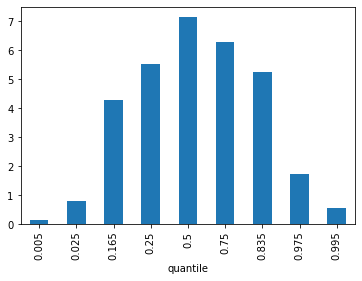

In [14]:
proph_eval.groupby('quantile')['wpl'].mean().plot.bar()

### The tail (28 test)

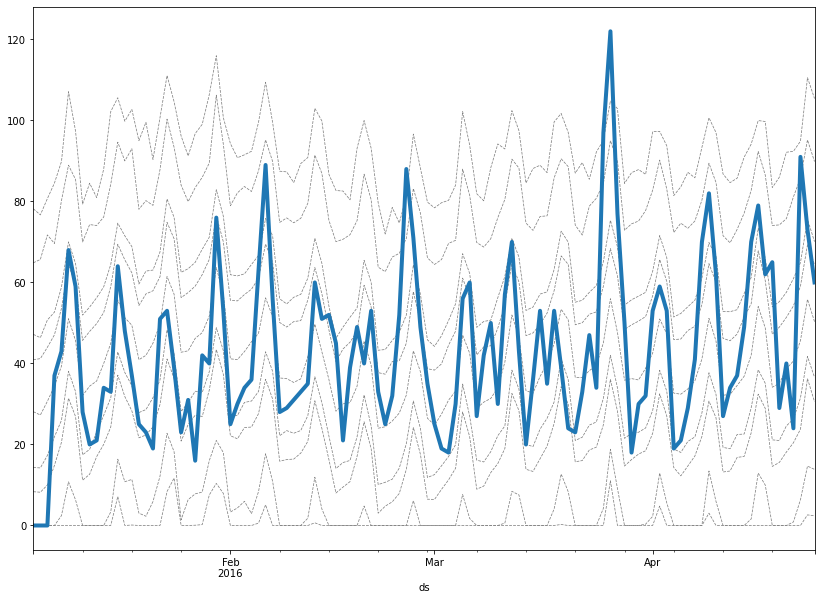

In [24]:
lookback = 28*4
fig, ax = plt.subplots(figsize = (14,10))
pred_quantiles_ds.iloc[-lookback:,:].plot(ax = ax, **{'ls': '--', 'color': 'grey', 'linewidth': 0.75})
pd.Series(s.tseries.values, index = sales_df['ds']).iloc[-lookback:].plot(ax = ax, **{'linewidth':4})
ax.get_legend().remove()

### Worst days

In [16]:
worst = proph_eval.groupby('index').sum()['wpl'].sort_values().tail(10)
tsds = pd.Series(s.tseries.values, index = sales_df['ds'])
worst

index
287     231.925839
6       277.160399
308     285.408355
1761    290.235119
0       302.091788
1067    311.836189
1597    321.520475
239     352.114941
947     352.388949
298     717.867744
Name: wpl, dtype: float64

In [17]:
worst_idx = worst.index[-3:]
worst_idx

Int64Index([239, 947, 298], dtype='int64', name='index')

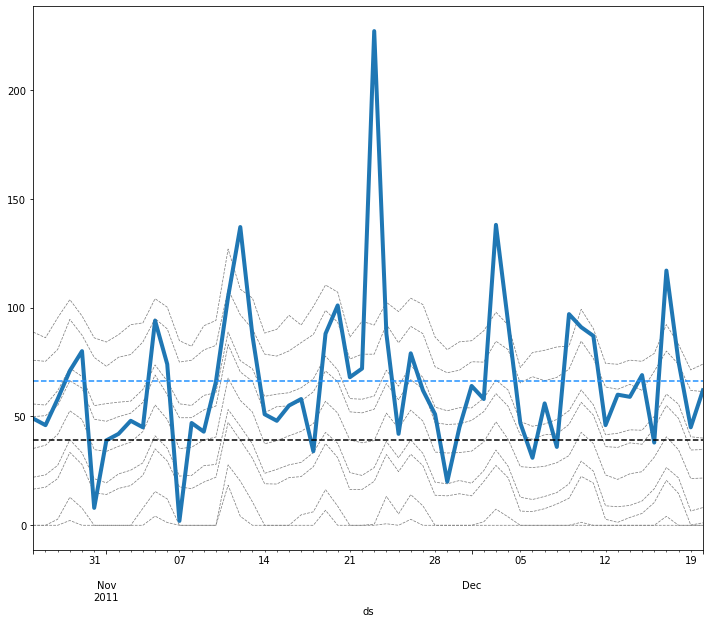

In [46]:
i = worst_idx[2]
start = i-28
fin = i+28
fig, ax = plt.subplots(figsize = (12,10))
pred_quantiles_ds.iloc[start:fin:,:].plot(ax = ax, **{'ls': '--', 'color': 'grey', 'linewidth': 0.75})
tsds.iloc[start:fin:].plot(ax = ax, **{'linewidth':4})
ax.axhline(tsds.iloc[start:fin:].mean(), color = 'dodgerblue', ls = '--')
ax.axhline(pred_quantiles_ds.iloc[start:fin:,4].mean(), color = 'black', ls = '--')
ax.get_legend().remove()

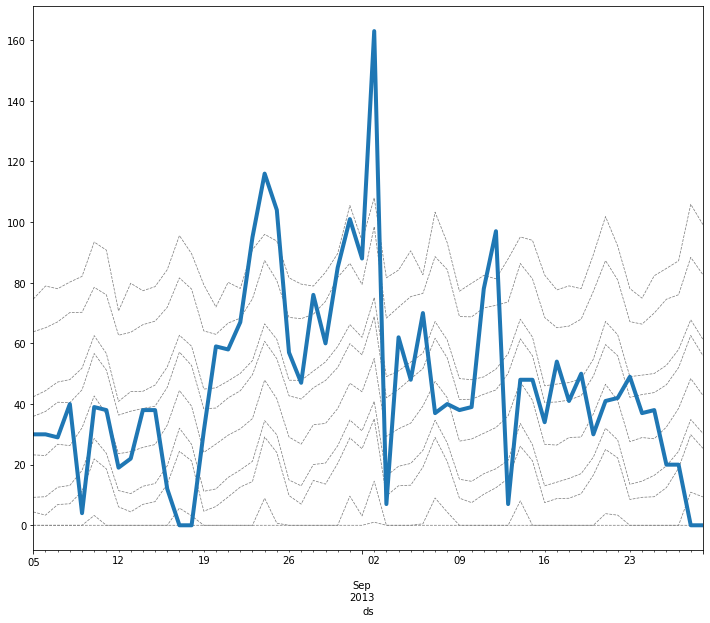

In [19]:
i = worst_idx[2]
start = i-28
fin = i+28
fig, ax = plt.subplots(figsize = (12,10))
pred_quantiles_ds.iloc[start:fin:,:].plot(ax = ax, **{'ls': '--', 'color': 'grey', 'linewidth': 0.75})
tsds.iloc[start:fin:].plot(ax = ax, **{'linewidth':4})
ax.axhline(tsds.iloc[start:fin:].mean(), color = 'dodgerblue', ls = '--')
ax.axhline(pred_quantiles_ds.iloc[start:fin:,4].mean(), color = 'black', ls = '--')
ax.get_legend().remove()

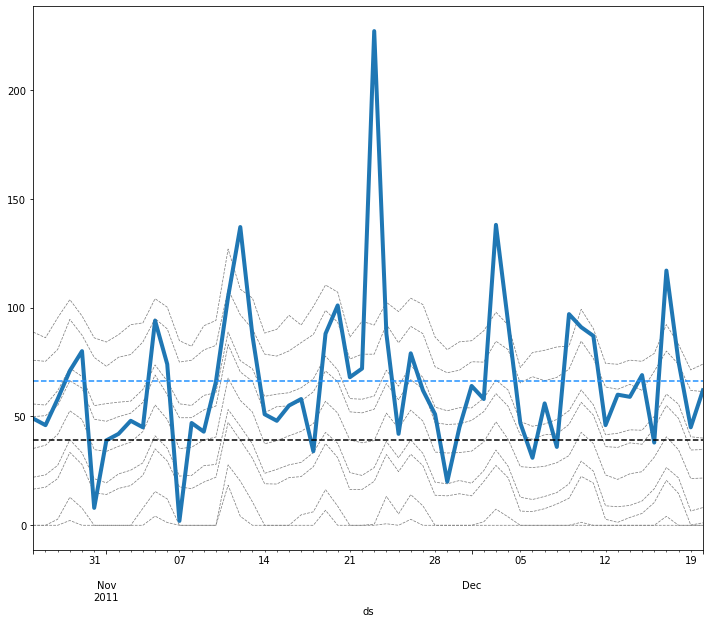

In [45]:
i = worst_idx[2]
start = i-28
fin = i+28
fig, ax = plt.subplots(figsize = (12,10))
pred_quantiles_ds.iloc[start:fin:,:].plot(ax = ax, **{'ls': '--', 'color': 'grey', 'linewidth': 0.75})
tsds.iloc[start:fin:].plot(ax = ax, **{'linewidth':4})
ax.axhline(tsds.iloc[start:fin:].mean(), color = 'dodgerblue', ls = '--')
ax.axhline(pred_quantiles_ds.iloc[start:fin:,4].mean(), color = 'black', ls = '--')
ax.get_legend().remove()

### Change Detection

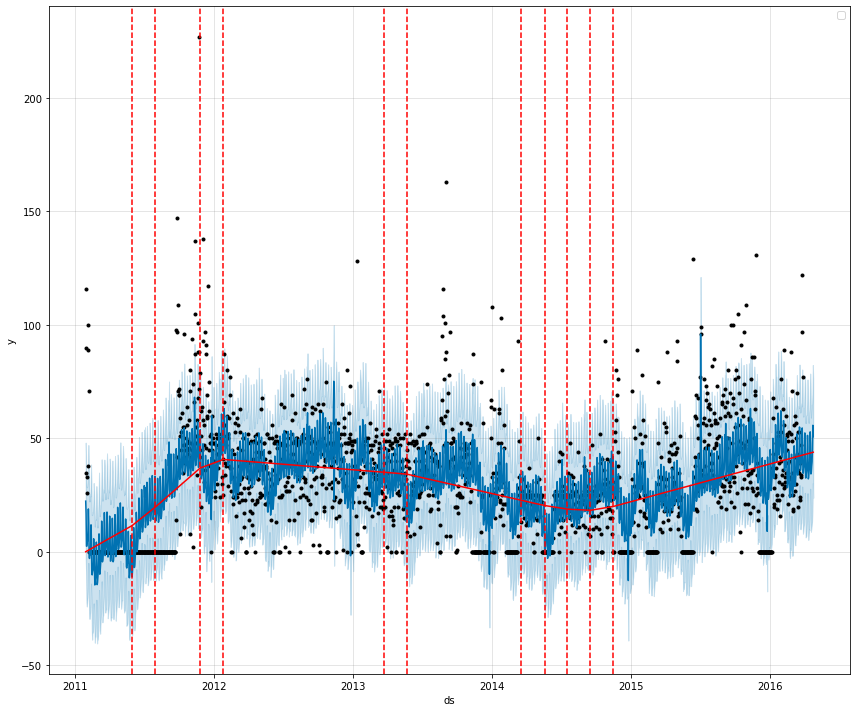

In [21]:
pal = sns.color_palette('deep')
nice = pal.as_hex()
reds = ['#FFA07A', '#FA8072', '#E9967A', '#F08080', '#CD5C5C', '#DC143C', '#B22222', '#FF0000', '#8B0000', '#800000', '#FF6347', '#FF4500']
fig, ax = plt.subplots(figsize = (12,10))
model.plot(forecast, ax = ax)
# for q, v in eqmodel_fit.iteritems():
#     if v > 0:
#         ax.axhline(eqmodel_fit[q], label = q, color = reds.pop())
ax.legend(loc = 'upper right')
a = add_changepoints_to_plot(fig.gca(), model, forecast)

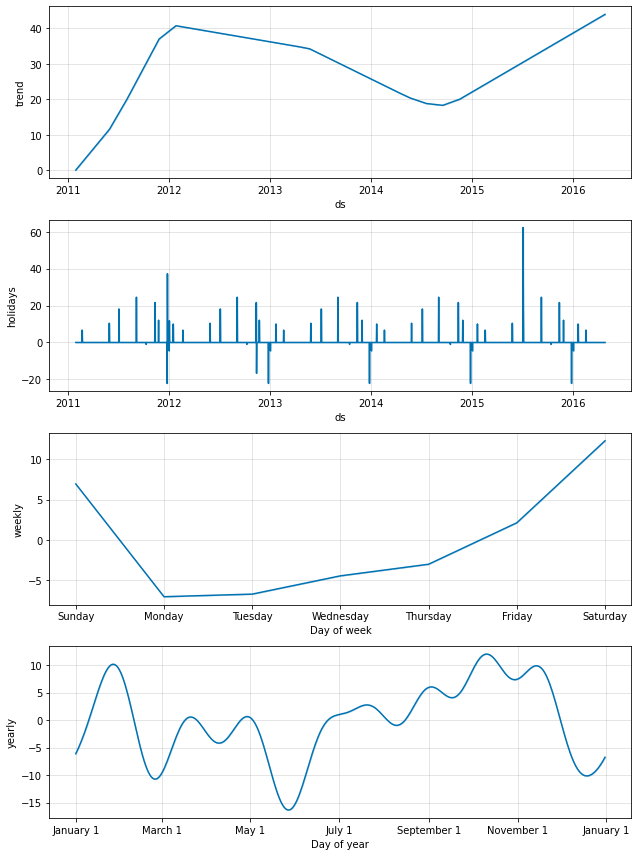

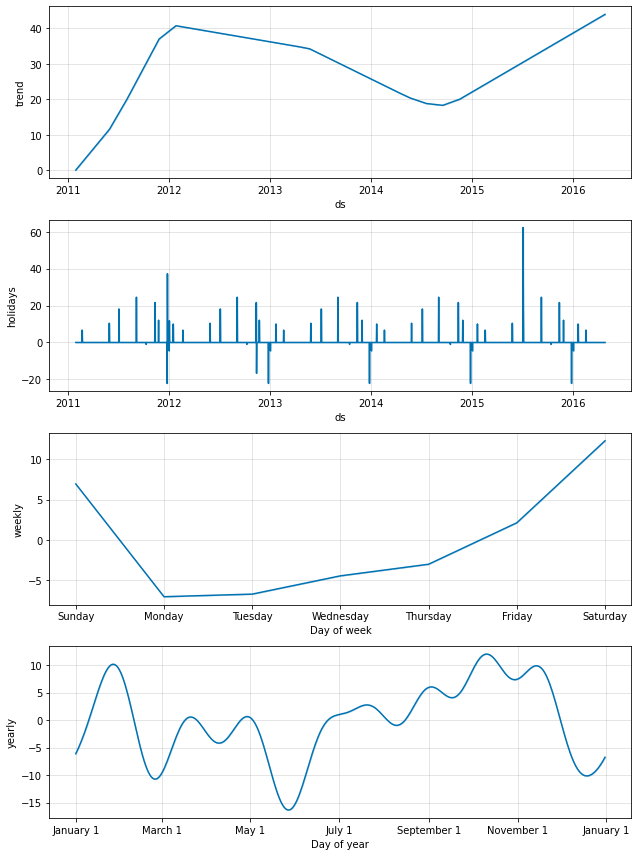

In [22]:
model.plot_components(forecast)